## Processing Landsat 8 Imagery into Chlorophyll-a

This code processes L8 imagery into chl-a (using the OCx algorithm) and compares the (provisional) Aquatic Reflectance Product from USGS to their standard level two surface reflectance product.

Aquatic reflectance imagery can be ordered here: https://espa.cr.usgs.gov/

More information on the product is here: https://www.usgs.gov/core-science-systems/nli/landsat/landsat-provisional-aquatic-reflectance

And the standard Landsat data can be ordered here: https://earthexplorer.usgs.gov/


Import all the necessary packages

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import unpackqa
import math

import hvplot.xarray
import cartopy.crs as crs

## pull in all the imagery

### first the aquatic reflectance product

In [2]:
import glob
fns = glob.glob('data/LC090140362021110902T1-SC20220920222557_aquatic_ref/*AR_BAND*.tif')
fns = sorted(fns)
fns

['data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND1.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND2.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND3.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND4.tif',
 'data/LC090140362021110902T1-SC20220920222557_aquatic_ref/LC09_L1TP_014036_20211109_20220119_02_T1_AR_BAND5.tif']

In [3]:
# this is the UTM 18N coordinates we'll subset the imagery with
y_slice = slice(3.905e6,3.8e6)

In [4]:
# merge the bands into an xarray dataset
bands = []
for fn in fns:
    bands.append(xr.open_rasterio(fn).isel(band=0).sel(y=y_slice))
    
# assign names to the bands
for i, b in enumerate(bands):
    b.name = "band"+str(i+1)
    
# merge the bands into a single dataset where the bands are variables
aq_dataset = xr.merge(bands)

aq_dataset

<xarray.Dataset>
Dimensions:  (x: 7681, y: 3500)
Coordinates:
    band     int64 1
  * y        (y) float64 3.905e+06 3.905e+06 3.905e+06 ... 3.8e+06 3.8e+06
  * x        (x) float64 2.709e+05 2.709e+05 2.71e+05 ... 5.013e+05 5.013e+05
Data variables:
    band1    (y, x) int16 ...
    band2    (y, x) int16 ...
    band3    (y, x) int16 ...
    band4    (y, x) int16 ...
    band5    (y, x) int16 ...

check the coordinate reference system

In [5]:
aq_dataset.band1.crs

'+init=epsg:32618'

EPSG:32618 is WGS 84 / UTM zone 18N

Now check the no data value

In [6]:
aq_dataset.band1.nodatavals

(-9999.0,)

The nan value is -9999 so let's set that to nan for visualizations

In [7]:
aq_dataset['band1'] = aq_dataset.band1.where(aq_dataset.band1 != -9999)
aq_dataset['band2'] = aq_dataset.band2.where(aq_dataset.band2 != -9999)
aq_dataset['band3'] = aq_dataset.band3.where(aq_dataset.band3 != -9999)
aq_dataset['band4'] = aq_dataset.band4.where(aq_dataset.band4 != -9999)
aq_dataset['band5'] = aq_dataset.band5.where(aq_dataset.band5 != -9999)

Scale it back to Rrs since it is scaled by 10000

In [8]:
aq_dataset['band1'] = aq_dataset.band1*0.00001/math.pi
aq_dataset['band2'] = aq_dataset.band2*0.00001/math.pi
aq_dataset['band3'] = aq_dataset.band3*0.00001/math.pi
aq_dataset['band4'] = aq_dataset.band4*0.00001/math.pi
aq_dataset['band5'] = aq_dataset.band5*0.00001/math.pi

Check out the histogram of this imagery

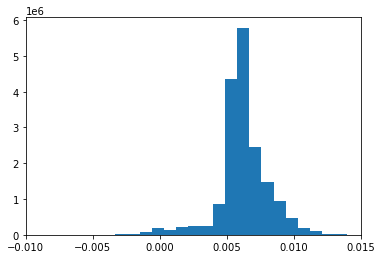

In [9]:
plt.hist(aq_dataset.band1.values.flatten(),bins=150)
plt.xlim(-0.01,.015)
plt.show()

## plot it

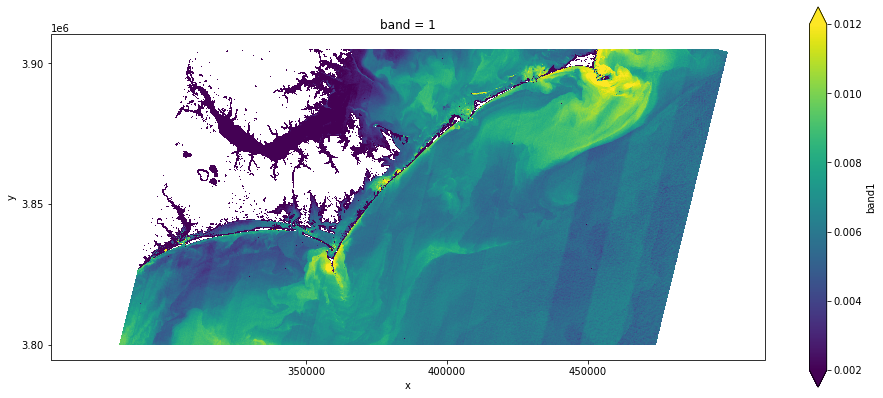

In [10]:
fig,ax = plt.subplots(figsize=(16,7), subplot_kw=dict(projection=crs.UTM('18N')))
aq_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.002,vmax=0.012)

ax.set_xticks([350000,400000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.8e6,3.85e6,3.9e6], crs=crs.UTM('18N'))

fig.savefig('landsat9_band1_aq.png',dpi=300)

### now the surface reflectance product

In [11]:
import glob
fns = glob.glob('data/surf2021/*SR_B*.TIF')
fns = sorted(fns)
fns

['data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B1.TIF',
 'data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B2.TIF',
 'data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B3.TIF',
 'data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B4.TIF',
 'data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_SR_B5.TIF']

In [12]:
y_slice

slice(3905000.0, 3800000.0, None)

In [13]:
bands = []
for fn in fns:
     bands.append(xr.open_rasterio(fn).isel(band=0).sel(y=y_slice))
    
# assign names to the bands
for i, b in enumerate(bands):
    b.name = "band"+str(i+1)
    
# merge the bands into a single dataset where the bands are variables
sr_dataset = xr.merge(bands)

sr_dataset

<xarray.Dataset>
Dimensions:  (x: 7681, y: 3500)
Coordinates:
    band     int64 1
  * y        (y) float64 3.905e+06 3.905e+06 3.905e+06 ... 3.8e+06 3.8e+06
  * x        (x) float64 2.709e+05 2.709e+05 2.71e+05 ... 5.013e+05 5.013e+05
Data variables:
    band1    (y, x) uint16 ...
    band2    (y, x) uint16 ...
    band3    (y, x) uint16 ...
    band4    (y, x) uint16 ...
    band5    (y, x) uint16 ...

grab bit mask from QA_PIXEL band we'll use this to mask out the land pixels

In [14]:
sr_qa_band = xr.open_rasterio('data/surf2021/LC09_L2SP_014036_20211109_20220119_02_T1_QA_PIXEL.TIF').isel(band=0).sel(y=y_slice)

In [15]:
# use the unpackqa package to grab the water bit flag
water_only_mask = unpackqa.unpack_to_array(sr_qa_band.values, 
                                           product='LANDSAT_8_C2_L2_QAPixel', 
                                           flags=['Water'])

What is the coordinate reference system?

In [16]:
sr_dataset.band1.crs

'+init=epsg:32618'

In [17]:
sr_dataset.band1.nodatavals

(0.0,)

We could also mask with the SR no dataval 0 but this takes care of both

In [18]:
sr_dataset['band1'] = sr_dataset.band1.where(water_only_mask == 1)
sr_dataset['band2'] = sr_dataset.band2.where(water_only_mask == 1)
sr_dataset['band3'] = sr_dataset.band3.where(water_only_mask == 1)
sr_dataset['band4'] = sr_dataset.band4.where(water_only_mask == 1)
sr_dataset['band5'] = sr_dataset.band5.where(water_only_mask == 1)

Now properly scale this data back to surface reflectance. First we divide by the scaling factor, then subtract the offset, then divide by pi to put it in the same units as Rrs

In [19]:
sr_dataset['band1'] = (sr_dataset.band1*0.0000275-0.2)/math.pi
sr_dataset['band2'] = (sr_dataset.band2*0.0000275-0.2)/math.pi
sr_dataset['band3'] = (sr_dataset.band3*0.0000275-0.2)/math.pi
sr_dataset['band4'] = (sr_dataset.band4*0.0000275-0.2)/math.pi
sr_dataset['band5'] = (sr_dataset.band5*0.0000275-0.2)/math.pi

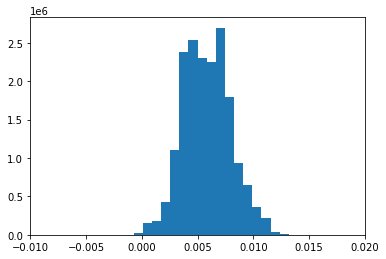

In [20]:
plt.hist(sr_dataset.band1.values.flatten(),bins=150)
plt.xlim(-0.01,.02)
plt.show()

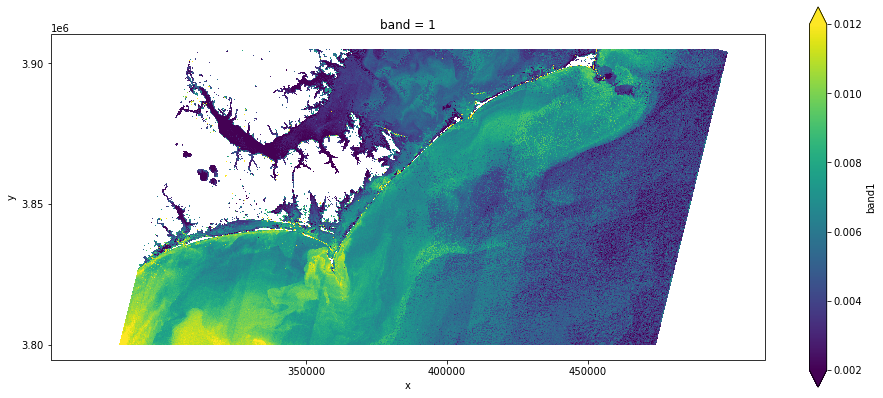

In [21]:
fig,ax = plt.subplots(figsize=(16,7), subplot_kw=dict(projection=crs.UTM('18N')))
sr_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.002,vmax=0.012)

ax.set_xticks([350000,400000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.8e6,3.85e6,3.9e6], crs=crs.UTM('18N'))

fig.savefig('landsat9_band1_sr.png',dpi=300)

In [22]:
sr_dataset

<xarray.Dataset>
Dimensions:  (x: 7681, y: 3500)
Coordinates:
    band     int64 1
  * y        (y) float64 3.905e+06 3.905e+06 3.905e+06 ... 3.8e+06 3.8e+06
  * x        (x) float64 2.709e+05 2.709e+05 2.71e+05 ... 5.013e+05 5.013e+05
Data variables:
    band1    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    band2    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    band3    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    band4    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    band5    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [23]:
ds_sr_mean = sr_dataset.sel(y=slice(3.8005e6,3.8e6),x=slice(450000,450500))#.mean(dim=('x','y'))
ds_aq_mean = aq_dataset.sel(y=slice(3.8005e6,3.8e6),x=slice(450000,450500))#.mean(dim=('x','y'))

In [24]:
modis_means=np.array([0.0060261204,
 0.0049827616,
 0.004647762,
 0.004143001,
 0.0019218815,
 0.0014784792,
 0.0012422072,
 0.00013921835,
 0.0001760877,
 0.00019414212])
modis_stds = np.array([0.00024047808,
 0.00016367083,
 0.00015202448,
 9.99581e-05,
 4.4697794e-05,
 4.1281608e-05,
 6.0172064e-05,
 3.4974695e-05,
 1.9988835e-05,
 1.6809237e-05])
modis_wavelengths=np.array([412, 443, 469, 488, 531, 547, 555, 645, 667, 678])

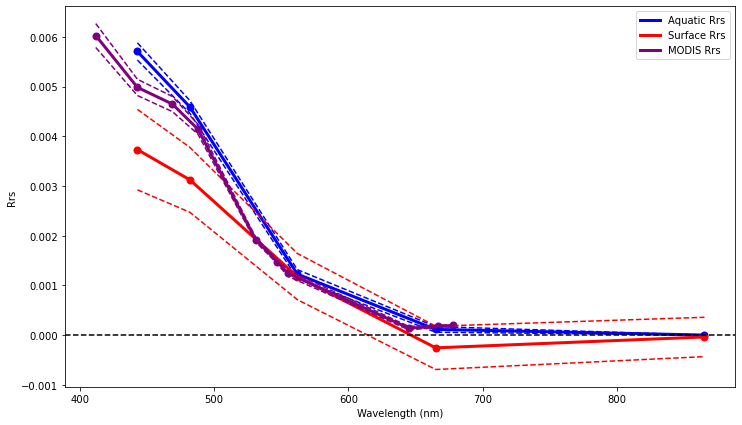

In [25]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,lw=3, label='Aquatic Rrs')
ax.scatter(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,lw=2)

ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean()+ds_aq_mean[i].values.flatten().std() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,ls='--')
ax.plot(np.array([443,482,562,665,865]),np.array([ds_aq_mean[i].values.flatten().mean()-ds_aq_mean[i].values.flatten().std() for i in ds_aq_mean.data_vars]),color='blue',alpha=1,ls='--')


ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean() for i in ds_sr_mean.data_vars]),color='red',alpha=1,lw=3,label='Surface Rrs')
ax.scatter(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean() for i in ds_sr_mean.data_vars]),color='red',alpha=1,lw=2)

ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean()+ds_sr_mean[i].values.flatten().std() for i in ds_sr_mean.data_vars]),color='red',alpha=1,ls='--')
ax.plot(np.array([443,482,562,665,865]),np.array([ds_sr_mean[i].values.flatten().mean()-ds_sr_mean[i].values.flatten().std() for i in ds_sr_mean.data_vars]),color='red',alpha=1,ls='--')

ax.plot(modis_wavelengths, modis_means,c='purple',lw=3,label='MODIS Rrs')
ax.scatter(modis_wavelengths, modis_means,c='purple',lw=2)
ax.plot(modis_wavelengths, modis_means+modis_stds,c='purple',ls='--')
ax.plot(modis_wavelengths, modis_means-modis_stds,c='purple',ls='--')

ax.set_ylabel('Rrs')
ax.set_xlabel('Wavelength (nm)')

ax.legend()


ax.axhline(0,ls='--',c='k')
plt.savefig('rrs_comparison.png',dpi=450)
plt.show()

## convert to chla and compare

Run the NASA chlorophyll algorithm using algorithm coefficients for L8 from https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/


In [26]:
# define the OCx algorithm using landsat coefficients
def oc3(band1,band2,band3):
    # landsat 8 coefs
    a0 = 0.2412
    a1 = -2.0546
    a2 = 1.1776
    a3 = -0.5538
    a4 = -0.4570

    # get the max blue band
    mbr = np.maximum(band1, band2)

    log10chl = a0 + a1 * (np.log10(mbr / band3)) \
        + a2 * (np.log10(mbr / band3))**2 \
            + a3 * (np.log10(mbr / band3))**3 \
                + a4 * (np.log10(mbr / band3))**4

    oc3_chla = np.power(10, log10chl)
    return(oc3_chla)

#### Apply the algorithm

we also filter outlier values above 50 and below 0.0001

In [27]:
oc3_chla_aq = oc3(aq_dataset.band1, aq_dataset.band2,aq_dataset.band3)
oc3_chla_aq = oc3_chla_aq.where(oc3_chla_aq < 50)
oc3_chla_aq = oc3_chla_aq.where(oc3_chla_aq > 0.0001)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [28]:
oc3_chla_sr = oc3(sr_dataset.band1, sr_dataset.band2, sr_dataset.band3)
oc3_chla_sr = oc3_chla_sr.where(oc3_chla_sr < 50)
oc3_chla_sr = oc3_chla_sr.where(oc3_chla_sr > 0.0001)

compare histograms

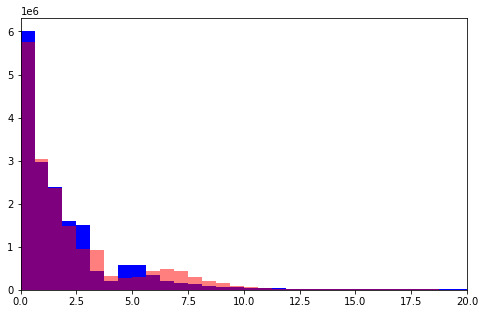

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(oc3_chla_aq.values.flatten(),bins=80,color='blue')
ax.hist(oc3_chla_sr.values.flatten(),bins=80,color='red',alpha=0.5)
ax.set_xlim(0,20)
plt.show()

In [30]:
import cmocean

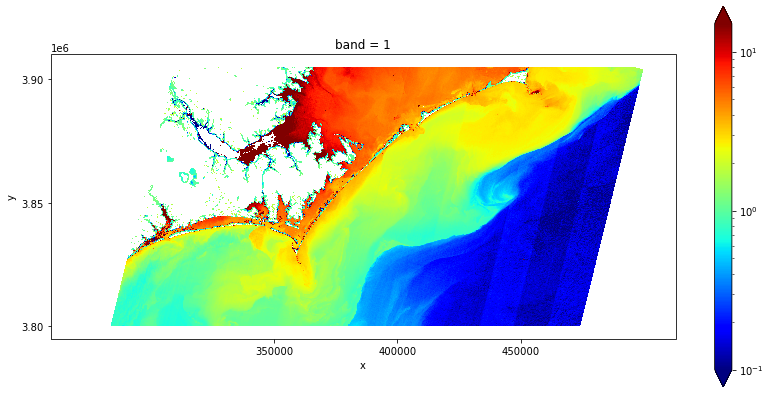

In [31]:
fig,ax = plt.subplots(figsize=(14,7), subplot_kw=dict(projection=crs.UTM('18N')))
oc3_chla_aq.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.1, vmax=15))

ax.set_xticks([350000,400000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.8e6,3.85e6,3.9e6], crs=crs.UTM('18N'))

fig.savefig('landsat9_chla_grid_aq.png',dpi=300)

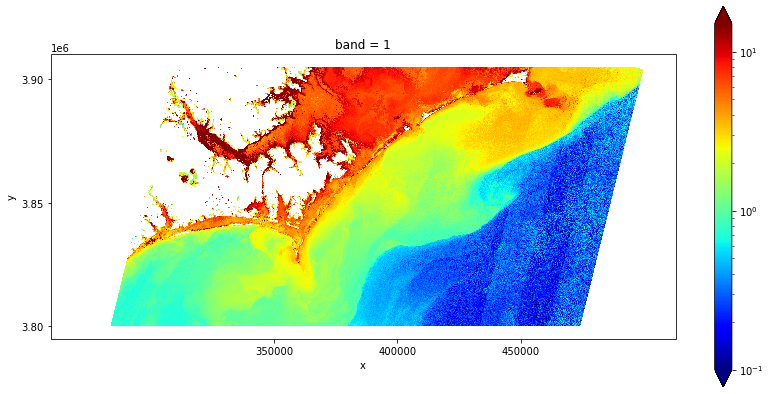

In [32]:
fig,ax = plt.subplots(figsize=(14,7), subplot_kw=dict(projection=crs.UTM('18N')))
oc3_chla_sr.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.1, vmax=15))
ax.set_xticks([350000,400000,450000], crs=crs.UTM('18N'))
ax.set_yticks([3.8e6,3.85e6,3.9e6], crs=crs.UTM('18N'))
fig.savefig('landsat9_chla_grid_sr.png',dpi=300)

In [ ]:
sr_dataset

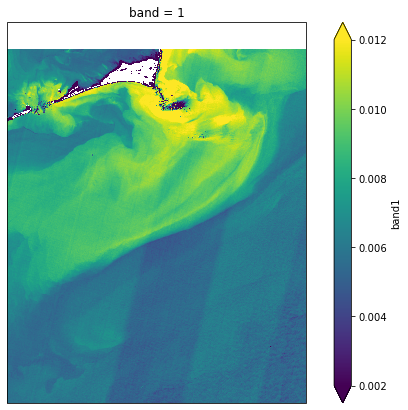

In [45]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

aq_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.002,vmax=0.012)
ax.set_xlim(425000,480000)
ax.set_ylim(3.84e6,3.91e6)
fig.savefig('landsat9_blue_hatteras_aq.png',dpi=300)
plt.show()

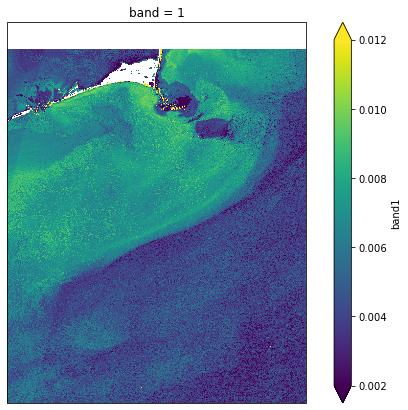

In [46]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

sr_dataset.band1.plot(ax=ax, cmap='viridis',vmin=0.002,vmax=0.012)
ax.set_xlim(425000,480000)
ax.set_ylim(3.84e6,3.91e6)
fig.savefig('landsat9_blue_hatteras_sr.png',dpi=300)
plt.show()

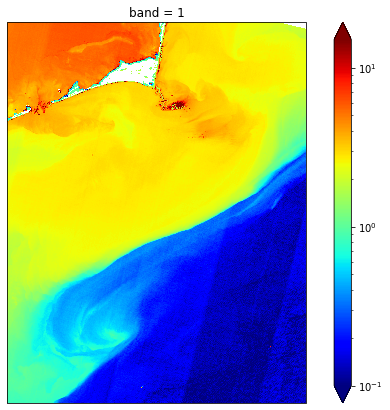

In [12]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_aq.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=.1, vmax=15))
ax.set_xlim(425000,480000)
ax.set_ylim(3.84e6,3.91e6)
fig.savefig('landsat9_chla_hatteras_aq.png',dpi=300)
plt.show()

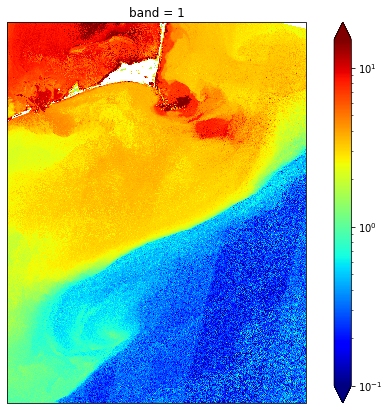

In [16]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_sr.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=.1, vmax=15))
ax.set_xlim(425000,480000)
ax.set_ylim(3.84e6,3.91e6)
fig.savefig('landsat9_chla_hatteras_sr.png',dpi=300)
plt.show()

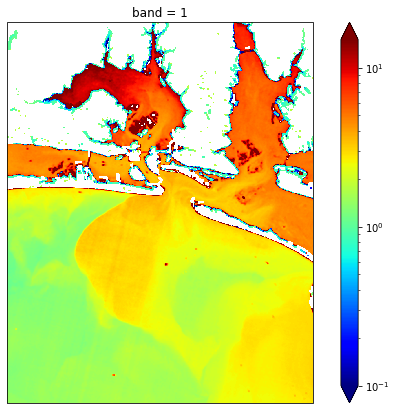

In [13]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_aq.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=.1, vmax=15))
ax.set_xlim(335000,357500)
ax.set_ylim(3.825e6,3.853e6)
fig.savefig('landsat9_chla_beaufort_aq.png',dpi=300)

plt.show()

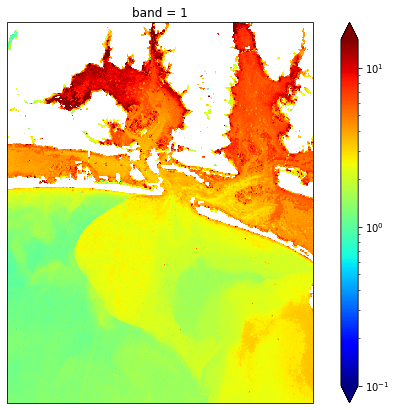

In [17]:
fig, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=crs.UTM('18N')))
# ax.coastlines(resolution='10m')

oc3_chla_sr.plot(ax=ax, cmap='jet', norm=LogNorm(vmin=.1, vmax=15))
ax.set_xlim(335000,357500)
ax.set_ylim(3.825e6,3.853e6)

fig.savefig('landsat9_chla_beaufort_sr.png',dpi=300)
plt.show()